In [152]:
import sys
import tes.simulation.data as sim
from tes.simulation.data import PacketStream, Data, Distribution
from tes.simulation.filesets import measurement_subsystem_TB as fileset
import tes.simulation.plot as splt
import numpy as np
import matplotlib.pyplot as plt
import math
import collections

In [ ]:
import serial.tools.list_ports
for p in serial.tools.list_ports.comports():
    print(p)

In [153]:
data=Data(fileset, 8, 'teslib','measurement_subsystem_TB')
enet=PacketStream(data.byte_stream)
dists=enet.distributions

In [ ]:
data.save('4channelShort.pickle')

In [148]:
data.ethernet_stream

array([(6485467150365874689, False), (144964034820909056, False),
       (33554432, False), (1099511824896, False),
       (144115188075855872, True), (6485467150365874689, False),
       (144964034820909056, False), (72058693583110144, False),
       (1099511889919, False), (144116287587483648, True)], 
      dtype=[('data', '>u8'), ('last', '?')])

In [ ]:
# compare transmitted distributions with the data
failed=False
if dists == []:
    print('No distributions')
else:
    for dist in dists:
        dif = (dist.counts - dist.data_counts(data))[0].nonzero()
        if dif[0].size:
            print('{:}\nDoes not reconcile with the data, Differences at {:d} indexs:\n{:}\n'.format(
                    dist, dif[0].size, dif[0]))
            failed=True
    if not failed:
        print('Distributions agree with data')
    


 ## work area

In [154]:
enet.packets

[ethertype:88B5 length:40 Payload:tick frame:0 protocol:0,
 ethertype:88B5 length:40 Payload:tick frame:1 protocol:1,
 ethertype:88B5 length:32 Payload:peak frame:2 protocol:2,
 ethertype:88B5 length:48 Payload:pulse frame:3 protocol:3,
 ethertype:88B5 length:56 Payload:pulse frame:4 protocol:4,
 ethertype:88B5 length:1488 Payload:trace frame:5 protocol:0,
 ethertype:88B5 length:1320 Payload:trace frame:6 protocol:1]

In [108]:
data.byte_stream

array([(36, 90, False), (38, 1, False), (40, 2, False), (42, 3, False),
       (44, 4, False), (46, 5, False), (48, 218, False), (50, 1, False),
       (52, 2, False), (54, 3, False), (56, 4, False), (58, 5, False),
       (60, 136, False), (62, 181, False), (64, 40, False), (66, 0, False),
       (68, 0, False), (70, 0, False), (72, 0, False), (74, 0, False),
       (76, 2, False), (78, 0, False), (80, 0, False), (82, 0, False),
       (84, 0, False), (86, 0, False), (88, 1, False), (90, 0, False),
       (92, 0, False), (94, 3, False), (96, 2, False), (98, 0, False),
       (100, 2, False), (102, 0, False), (104, 0, False), (106, 0, False),
       (108, 0, False), (110, 0, False), (112, 0, False), (114, 0, True)], 
      dtype=[('index', '<u4'), ('data', 'u1'), ('last', '?')])

<IPython.core.display.Javascript object>


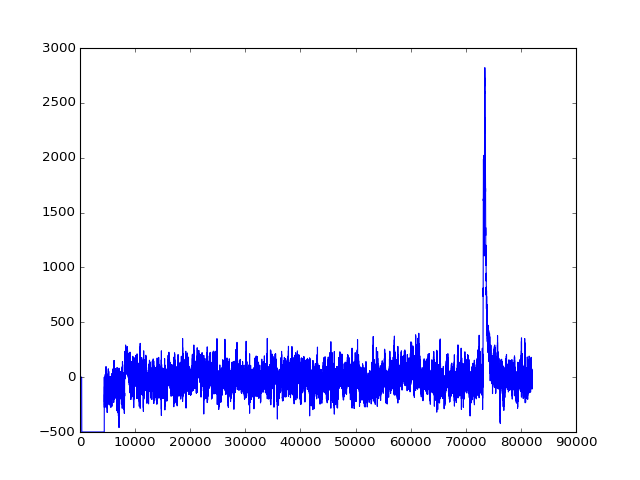

In [155]:
%matplotlib notebook
plt.plot(data.trace[4]['raw'])

In [ ]:
enet.packets[4].payload[40:].view(np.uint32).size

In [ ]:
enet.packets[4].length

In [ ]:
dist=dists[1]
c=check_distribution(dist,data)
(c-dist.counts).nonzero()[0].size

In [ ]:
start=dist.start_time
stop=dist.stop_time+np.uint64(1)
s=data.slice((start, stop))
f = s.trace[dist.channel]['filtered']
fd = data.trace[dist.channel]['filtered'][start:stop]
(f-fd).nonzero()

In [ ]:
np.uint64(1)+np.uint64(-1)

In [ ]:
event_dt=np.dtype(
    (np.uint64, 
        [
            ('data', np.uint32),
            ('flags0', np.uint8),
            ('flags1', np.uint8),
            ('time',np.uint16)
        ] 
    )
)

peak_dt=np.dtype(
    (
        [
            ('height', np.int16),
            ('minima', np.int16),
            ('flags0', np.uint8),
            ('flags1', np.uint8),
            ('time',np.uint16)
        ] 
    )
)

tick_dt=np.dtype(
    ( 
        [
            ('period', np.uint32),
            ('flags0', np.uint8),
            ('flags1', np.uint8),
            ('time', np.uint16),
            ('timestamp', np.uint64)
        ]
    )
)

e = sim.EventStream('teslib','measurement_subsystem_TB')

events=e._stream64.view(dtype=event_dt)

#type_flags = np.bitwise_and(events['flags'],0x000f)
tick = np.bitwise_and(events['flags1'],0x02)!=0
window_start = np.bitwise_and(events['flags1'],0x01)!=0

tick_mask=np.zeros(len(tick),dtype=bool)
i=0
while (i < len(tick)):
    if tick[i]!=0:
        tick_mask[i:i+2]=True
        i+=1
    i+=1
    
peaks=e._stream64[~tick_mask].view(dtype=peak_dt)

ticks=e._stream64[tick_mask].view(dtype=tick_dt)

In [ ]:
d=distributions[0]


d.value.trace

In [ ]:
%matplotlib notebook
stop=distributions[0].stop_time
start=distributions[0].start_time
plt.plot(data.trace[0]['filtered'][start:stop])

In [ ]:
%matplotlib notebook
d=0
plt.plot(distributions[d].counts)

In [ ]:
p=1
lasts=enet['last'].nonzero()[0]+1
packets = []
prev=0
for last in lasts:
    packets.append(sim.Packet( np.copy(enet['data'][prev:last]).view(np.uint8)))
    prev=last

packets[:]

In [ ]:
packets[4]

In [ ]:
def get_distributions(packets):
    for packet in packets:
        if packet.payload_type == PayloadType.mca:
            
        
    
    
    
packets[4].payload[0:8].view(mca_header_dt)

In [ ]:
peaks=packets[1].payload.view(peak_dt)
peaks

In [ ]:

time=0
times=[]
heights=[]
minimas=[]

for p in packets:
    if p.payload_type==sim.EventType.tick:
        tick=p.payload.view(tick_dt)
        time=tick[0]['timestamp']
    elif p.payload_type==sim.EventType.peak:
        peaks=p.payload.view(peak_dt)
        for peak in peaks:
            time+=peak['time']
            times.append(time)
            heights.append(peak['height'])
            minimas.append(peak['minima'])
            

In [ ]:
times

In [ ]:
packets[1].payload.view(peak_dt)

In [ ]:
heights[0]

In [ ]:
%matplotlib notebook
p=3
x=np.arange(times[p]-300,times[p]+1000,dtype=np.uint64)
plt.plot([times[p], times[p]],[minimas[p], heights[p]],'r',lw=2)
plt.step(x,data.trace['filtered'][x])
plt.plot(data.peak[p/2],data.trace['filtered'][data.peak[p/2]],'ro')
plt.plot(
    [data.peak_start[p/2],times[p]],
    [data.trace['filtered'][data.peak_start[p/2]],data.trace['filtered'][data.peak_start[p/2]]],
    'k'
)
plt.plot(
    [times[p],data.peak[p/2]],
    [data.trace['filtered'][data.peak[p/2]],data.trace['filtered'][data.peak[p/2]]],
    'k'
)

In [ ]:
%matplotlib notebook
fig=simplt.plot_slice(data.slice((data.peak[0]-1000,data.peak[0]+1000)))
data.trace['filtered'][data.peak[0]]

In [ ]:
data.cfd_low

In [ ]:
packet_bytes=packet.view(np.uint8)

In [ ]:
packet_bytes

In [ ]:

payload

In [ ]:

payload_type

In [ ]:
time=payload[6:8].view(np.uint16)
time

In [ ]:

peaks

In [ ]:
payload[4+8:6+8]

In [ ]:
%matplotlib notebook
fig=simplt.plot_pulse(1,data)

In [ ]:
fig._axstack.as_list()[0]

In [ ]:
tick

In [ ]:
ticks

In [ ]:
window_start

In [ ]:
tick_mask

In [ ]:
e._stream64[tick_mask]

In [ ]:
type_flags[~tick_mask]

In [ ]:
type_flags = np.bitwise_and(events['flags'],0x000f)
peak_num = np.right_shift(np.bitwise_and(events['flags'],0x00f0),4)
channel = np.right_shift(np.bitwise_and(events['flags'],0x0f00),8)
event_type = np.right_shift(np.bitwise_and(events['flags'],0x3000),12)
tick=np.bitwise_and(type_flags,0x0002)

In [ ]:
ticks

In [ ]:
tick_mask

In [ ]:
events[tick_mask]

In [ ]:
time=np.bitwise_and(events[~tick_mask]['time'],0x7fff)
c_start=np.bitwise_and(events[~tick_mask]['time'],0x8000)!=0

In [ ]:
events[tick_mask]['time']

In [ ]:
time

In [ ]:
np.binary_repr(time[0],width=16)

In [ ]:
events[~tick_mask]['min']

In [ ]:
events[~tick_mask]['height']

In [ ]:
%matplotlib notebook
fig = simplt.plot_pulse(1,data,pre=500,length=3000)


In [ ]:
import pickle

# An arbitrary collection of objects supported by pickle.

pickler = pickle.Pickler(open('long.pickle', 'wb'),pickle.HIGHEST_PROTOCOL)
pickler.dump(data)


In [ ]:
unpickler = pickle.Unpickler(open('long.pickle', 'rb'))
reg2=unpickler.load()
data2=unpickler.load()

In [ ]:
data2.trace['slope']

In [ ]:
reg2

In [ ]:
axs = fig.get_axes()
pax=axs[0].parasites
pax[0]._label
f_ins_ax=axs[1]
s_ins_ax=f_ins_ax.parasites[0]

In [ ]:
es=sim.Data.fromfile('eventstream',np.int32,'teslib','measurement_unit_TB')

In [ ]:
es

In [ ]:
data.peak[-1]

In [ ]:
s.peak

In [ ]:
isinstance(r,sim.DataRegion)

In [ ]:
r.peak

In [ ]:
i

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(data.trace['filtered'])

In [ ]:
ax=plt.gca()
t=ax.transData
t.transform([[0.1,0.2],[1,3]])

In [ ]:
x=np.array([0,1,2,3])
y=np.array([3,4,5,6])

xy=np.empty(shape=(4,2))

In [ ]:
xy[:,0]=x
xy[:,1]=y
t.transform(xy)

In [ ]:
# run to import isim data files

import numpy as np
import os
import matplotlib.pyplot as plt
import math
from enum import Enum

plt.rcParams["figure.figsize"]=[800./80,600./80]

repo='c:\\TES_project\\fpga_ise\\'
project='teslib'
testbench='measurement_unit_TB'
datafile='traces'
path=repo+project+'\\PlanAhead\\'+project+'.sim\\'+testbench+'\\'

traces_dt = np.dtype([('input', np.int32),('raw',np.int32),('filtered',np.int32),('slope',np.int32)])
traces=np.fromfile(path+'traces',traces_dt)
trigger=np.fromfile(path+'triggers',np.int32)
settings=np.fromfile(path+'settings',np.int32)
cfd_low=np.fromfile(path+'cfdlow',np.int32)
cfd_high=np.fromfile(path+'cfdhigh',np.int32)
peaks=np.fromfile(path+'peaks',np.int32)
peaks.shape=(-1,2)
peak_starts=np.fromfile(path+'peak_starts',np.int32)
#peak_starts.shape=(-1,2)
pulse_starts=np.fromfile(path+'peak_starts',np.int32)
settings=np.fromfile(path+'settings',np.int32)
cfd_low=np.fromfile(path+'cfdlow',np.int32)
cfd_high=np.fromfile(path+'cfdhigh',np.int32)
slope_xing=np.fromfile(path+'slopethreshxings',np.int32)


In [ ]:
settings[13]

In [ ]:
#create register dict from settings array

class height_type(Enum):
    def from_int(value):
        if value == 0:
            return height_type.peak_height
        elif value == 1:
            return height_type.cfd_high
        elif value == 2:
            return height_type.slope_integral
        else:
            raise AttributeError()
    peak_height=0
    cfd_high=1
    slope_integral=2

class trigger_type(Enum):
    def from_int(value):
        if value == 0:
            return trigger_type.pulse_threshold
        elif value == 1:
            return trigger_type.slope_threshold
        elif value == 2:
            return trigger_type.cfd_low
        else:
            raise AttributeError()
    pulse_threshold=0
    slope_threshold=1
    cfd_low=2

class event_type(Enum):
    def from_int(value):
        if value == 0:
            return event_type.peak
        elif value == 1:
            return event_type.area
        elif value == 2:
            return event_type.pulse
        elif value == 3:
            return event_type.trace
        else:
            raise AttributeError()
    peak=0
    area=1
    pulse=2
    trace=3


def read_registers(settings):
    registers = dict()
    registers['baseline'] = dict()
    registers['baseline']['offset'] = settings[0]
    registers['baseline']['subtraction'] = settings[1]!=0
    registers['baseline']['timeconstant'] = settings[2]
    registers['baseline']['threshold'] = settings[3]
    registers['baseline']['count_threshold'] = settings[4]
    registers['generic'] = dict()
    registers['baseline']['average_order'] = settings[5]
    registers['capture'] = dict()
    registers['capture']['cfd_relative'] = settings[6]!=0
    registers['capture']['constant_fraction'] = settings[7]
    registers['capture']['pulse_threshold'] = settings[8]
    registers['capture']['slope_threshold'] = settings[9]
    registers['capture']['pulse_area_threshold'] = settings[10]
    registers['capture']['height_type'] = height_type.from_int(settings[11])
    registers['capture']['threshold_rel2min'] = settings[12]!=0
    registers['capture']['trigger_type'] = trigger_type.from_int(settings[13])
    registers['capture']['event_type'] = event_type.from_int(settings[14])
    return registers


In [ ]:
%matplotlib notebook
x=np.arange(len(traces['filtered']))
fig=plt.figure()

ax=fig.add_axes([0.15,0.1,0.8,0.8])
mV=1.0/math.pow(2,14)*1000
nS=4


i_trace, =ax.step(x*nS/1000000,(traces['input']+1800)*mV*2,'k',label='raw input')
f_trace, =ax.step(x*nS/1000000,traces['filtered']*mV,'b',label='processed')
fig.suptitle('Digital Signal Processing',fontsize=24)
plt.xlabel('time (ms)',fontsize=18)
plt.ylabel('Voltage (mV)',fontsize=18)
plt.legend(handles=[i_trace,f_trace])

fig.savefig('trace.png')
plt.show()

In [ ]:
%matplotlib notebook
import math

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)
    
x=np.arange(len(traces['filtered']))
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
plt.ylim(-10,120)
v=math.pow(2,13)/1000
t=x*4
ax.plot([0,t[-1]],[0,0],'k')
raw, = ax.step(t,traces['raw']/2/v,'k',lw=1,label='raw')
processed, = ax.step(t,traces['filtered']/2/v,'r',lw=2,label='processed')
ax.plot(trigger,traces['filtered'][trigger+1]/2,'kx')
ax.plot(peaks[:,0],traces['filtered'][peaks[:,0]+1]/2,'ro')
ax.plot(peak_starts,traces['filtered'][peak_starts+1]/2,'ro')
ax.plot(cfd_high,traces['filtered'][cfd_high+1]/2,'bs')
ax.plot(cfd_low,traces['filtered'][cfd_low+1]/2,'bs')
plt.xlabel('time (ns)',fontsize=18)
plt.ylabel('Voltage (mV)',fontsize=18,color='r')

ax2=ax.twinx()
slope, = ax2.step(t,traces['slope']/256/v/4,'b',lw=2,label='slope')
plt.xlim([1292000,1297500])
plt.ylim(-0.2,1)
align_yaxis(ax,0,ax2,0)
plt.ylabel('slope (mV/ns)',color='b',fontsize=18)
fig.suptitle('Digital signal processing',fontsize=24)
plt.legend(handles=[raw,processed,slope])
fig.savefig('dsp.png')
plt.show()

In [ ]:
%matplotlib notebook

#plot pulse
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

pulse=7
length=2000
pre=100

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)
    
start=pulse_starts[pulse]-pre
stop=start+length
x=np.arange(0,len(traces['filtered']))
fig=plt.figure()

f_ax = host_subplot(111)
s_ax = f_ax.twinx()

f_ax.set_xlabel("Time (ns)",fontsize=18)
f_ax.set_ylabel("Voltage (mV)",fontsize=18,color='r')
s_ax.set_ylabel("Slope (mv/ns)",fontsize=18,color='b')

mV=1.0/math.pow(2,14)*1000
nS=4
t=x*nS

f_sig = traces['filtered']*mV
s_sig = traces['slope']*mV/nS

f_ax.plot([t[start],t[stop]],[0,0],'k') # zero line
f_trace, = f_ax.step(t[start:stop],f_sig[start:stop],'r',lw=2,label='processed')
f_ax.set_ylim(-10,180)

s_trace, = s_ax.step(t[start:stop],s_sig[start:stop],'b',lw=1,label='slope')
s_ax.set_ylim(-15,50)
#s_threshold = 6
#s_ax.set_yticks(np.concatenate((s_ax.get_yticks(),[s_threshold])))
#labels=[label.get_text() for label in s_ax.get_yticklabels()]
#labels[6]='Threshold'

#s_ax.set_yticklabels(labels)
plt.xlim(t[start],t[stop])
align_yaxis(f_ax,0,s_ax,0)
fig.suptitle('Measurement:First pass',fontsize=24)
#plt.legend(handles=[f_trace,s_trace])

starts_mask = np.logical_and(peak_starts >= start,peak_starts <= stop)
peaks_mask = np.logical_and(peaks[:,0] >= start, peaks[:,0] <= stop)
peak_starts_inwin = peak_starts[starts_mask]

for pstart in peak_starts_inwin:
    peak_start_t=t[pstart]-2
    peak_start_f=f_sig[pstart]
    peak_start_s=s_sig[pstart]

    f_ax.plot(peak_start_t,peak_start_f,'ro')
    s_ax.plot(peak_start_t,peak_start_s,'bo')
    
    f_trans = f_ax.transData
    s_trans = s_ax.transData.inverted()
    trans = s_trans+f_trans
    f_point=f_trans.transform((peak_start_t,peak_start_f))
    s_point=s_trans.transform((f_point[0],f_point[1]))

    s_ax.plot([peak_start_t,peak_start_t],[peak_start_s, s_point[1]],'k')

#for p in peaks[0][peaks_inwin]
peaks_inwin = peaks[peaks_mask,0]
for p in peaks_inwin:
    peak_t=t[p]-2
    peak_f=f_sig[p]
    peak_s=s_sig[p]

    f_ax.plot(peak_t,peak_f,'ro')
    s_ax.plot(peak_t,peak_s,'bo')
    
    f_trans = f_ax.transData
    s_trans = s_ax.transData.inverted()
    trans = s_trans+f_trans
    f_point=f_trans.transform((peak_t,peak_f))
    s_point=s_trans.transform((f_point[0],f_point[1]))

    s_ax.plot([peak_t,peak_t],[peak_s, s_point[1]],'k')

ins_start = peak_starts_inwin[0]-5
ins_stop = peak_starts_inwin[0]+5
f_ins_ax = zoomed_inset_axes(f_ax, 50, loc=1)  # zoom = 6
f_ins_ax.step(t[ins_start:ins_stop],f_sig[ins_start:ins_stop],'r')
f_ins_ax.set_ylim(-0.5,2)
f_ins_ax.set_xlim(ins_start,ins_stop)
f_ins_ax.set_yticks([])
f_ins_ax.set_xticks([])

f_ins_ax.plot([t[ins_start],t[ins_stop]],[0,0],'k') # zero line

#plt.xticks(visible=False)
#plt.yticks(visible=False)
mark_inset(f_ax, f_ins_ax, loc1=2, loc2=4, fc="none", ec="0.5")

s_ins_ax = f_ins_ax.twinx()
s_ins_ax.set_yticks([])
s_ins_ax.set_xticks([])

s_ins_ax.step(t[ins_start:ins_stop],s_sig[ins_start:ins_stop],'b')

s_ins_ax.set_ylim(-1,1)
align_yaxis(f_ins_ax,0,s_ins_ax,0)

pstart = peak_starts_inwin[0]
peak_start_t=t[pstart]-2
peak_start_f=f_sig[pstart]
peak_start_s=s_sig[pstart]

f_ins_ax.plot(peak_start_t,peak_start_f,'ro')
s_ins_ax.plot(peak_start_t,peak_start_s,'bo')
    
f_trans = f_ins_ax.transData
s_trans = s_ins_ax.transData.inverted()
trans = s_trans+f_trans
f_point=f_trans.transform((peak_start_t,peak_start_f))
s_point=s_trans.transform((f_point[0],f_point[1]))

s_ins_ax.plot([peak_start_t,peak_start_t],[peak_start_s, s_point[1]],'k')

s_ax.plot([t[start],t[stop]],[s_threshold,s_threshold],ls='dashed')

fig.savefig('measurement1.png')
plt.draw()
plt.show()

In [ ]:
%matplotlib notebook
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

pulse=7
length=2000
pre=100

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)
    
start=pulse_starts[pulse]-pre
stop=start+length
x=np.arange(0,len(traces['filtered']))
fig=plt.figure()

f_ax = host_subplot(111)
s_ax = f_ax.twinx()

f_ax.set_xlabel("Time (ns)",fontsize=18)
f_ax.set_ylabel("Voltage (mV)",fontsize=18,color='r')
s_ax.set_ylabel("Slope (mv/ns)",fontsize=18,color='b')

mV=1.0/math.pow(2,14)*1000
nS=4
t=x*nS

f_sig = traces['filtered']*mV
s_sig = traces['slope']*mV/nS

f_ax.plot([t[start],t[stop]],[0,0],'k') # zero line
f_trace, = f_ax.step(t[start:stop],f_sig[start:stop],'r',lw=2,label='processed')
f_ax.set_ylim(-10,180)

s_trace, = s_ax.step(t[start:stop],s_sig[start:stop],'b',lw=1,label='slope')
s_ax.set_ylim(-15,50)
#s_threshold = 6
#s_ax.set_yticks(np.concatenate((s_ax.get_yticks(),[s_threshold])))
#labels=[label.get_text() for label in s_ax.get_yticklabels()]
#labels[6]='Threshold'

#s_ax.set_yticklabels(labels)
plt.xlim(t[start],t[stop])
align_yaxis(f_ax,0,s_ax,0)
fig.suptitle('Measurement:Second pass',fontsize=24)
#plt.legend(handles=[f_trace,s_trace])

starts_mask = np.logical_and(peak_starts >= start,peak_starts <= stop)
peaks_mask = np.logical_and(peaks[:,0] >= start, peaks[:,0] <= stop)
peak_starts_inwin = peak_starts[starts_mask]


#for pstart in peak_starts_inwin:
#    peak_start_t=t[pstart]-2
#    peak_start_f=f_sig[pstart]
#    peak_start_s=s_sig[pstart]
#
#    f_ax.plot(peak_start_t,peak_start_f,'ro')
#    s_ax.plot(peak_start_t,peak_start_s,'bo')
    
#    f_trans = f_ax.transData
#    s_trans = s_ax.transData.inverted()
#    trans = s_trans+f_trans
#    f_point=f_trans.transform((peak_start_t,peak_start_f))
#    s_point=s_trans.transform((f_point[0],f_point[1]))

#    s_ax.plot([peak_start_t,peak_start_t],[peak_start_s, s_point[1]],'k')

#for p in peaks[0][peaks_inwin]
peaks_inwin = peaks[peaks_mask,0]
x_s=peak_starts_inwin
x_p=peaks_inwin
y_s=f_sig[x_s]
y_p=f_sig[x_p]

f_ax.plot(t[peak_starts_inwin],f_sig[peak_starts_inwin],'or')
f_ax.plot(t[peaks_inwin],f_sig[peaks_inwin],'or')


f_ax.plot([t[x_s[0]],t[x_p[0]]],[y_s[0],y_s[0]],'k')
f_ax.plot([t[x_p[0]],t[x_p[0]]],[y_s[0],y_p[0]],'k')

f_ax.plot([t[x_s[1]],t[x_p[1]]],[y_s[1],y_s[1]],'k')
f_ax.plot([t[x_p[1]],t[x_p[1]]],[y_s[1],y_p[1]],'k')


#for p in peaks_inwin:
#    peak_t=t[p]-2
#    peak_f=f_sig[p]
#    peak_s=s_sig[p]

#    f_ax.plot(peak_t,peak_f,'ro')
#    s_ax.plot(peak_t,peak_s,'bo')
    
#    f_trans = f_ax.transData
#    s_trans = s_ax.transata.inverted()
#    trans = s_trans+f_trans
#    f_point=f_trans.transform((peak_t,peak_f))
#    s_point=s_trans.transform((f_point[0],f_point[1]))

#    s_ax.plot([peak_t,peak_t],[peak_s, s_point[1]],'k')

ins_start = peak_starts_inwin[1]-300
ins_stop = peak_starts_inwin[1]+500
f_ins_ax = zoomed_inset_axes(f_ax, 1.5, loc=1)  # zoom = 6
f_ins_ax.step(t[ins_start:ins_stop],f_sig[ins_start:ins_stop],'r')
f_ins_ax.set_ylim(60,180)
f_ins_ax.set_xlim(t[ins_start],t[ins_stop])
f_ins_ax.set_yticks([])
f_ins_ax.set_xticks([])

low_mask = np.logical_and(cfd_low >= start, cfd_low <= stop)
low_inwin = cfd_low[low_mask]
high_mask = np.logical_and(cfd_high >= start, cfd_high <= stop)
high_inwin = cfd_high[high_mask]
thresh_mask = np.logical_and(slope_xing >= start, slope_xing <= stop)
thresh_inwin = slope_xing[thresh_mask]

f_ins_ax.plot(t[peak_starts_inwin],f_sig[peak_starts_inwin],'or')
f_ins_ax.plot(t[peaks_inwin],f_sig[peaks_inwin],'or')

f_ins_ax.plot(t[low_inwin],f_sig[low_inwin],'ok')
f_ins_ax.plot(t[high_inwin],f_sig[high_inwin],'ok')
f_ax.plot(t[low_inwin],f_sig[low_inwin],'ok')
f_ax.plot(t[high_inwin],f_sig[high_inwin],'ok')
#f_ax.plot(t[thresh_inwin],f_sig[thresh_inwin],'ow')
f_ins_ax.plot(t[thresh_inwin],f_sig[thresh_inwin],'ow')


f_ins_ax.plot([t[x_s[0]],t[x_p[0]]],[y_s[0],y_s[0]],'k')
f_ins_ax.plot([t[x_p[0]],t[x_p[0]]],[y_s[0],y_p[0]],'k')

f_ins_ax.plot([t[x_s[1]],t[x_p[1]]],[y_s[1],y_s[1]],'k')
f_ins_ax.plot([t[x_p[1]],t[x_p[1]]],[y_s[1],y_p[1]],'k')

#f_ins_ax.plot([t[ins_start],t[ins_stop]],[0,0],'k') # zero line

#plt.xticks(visible=False)
#plt.yticks(visible=False)
#mark_inset(f_ax, f_ins_ax, loc1=2, loc2=4, fc="none", ec="0.5")

pstart = peak_starts_inwin[1]
peak_start_t=t[pstart]-2
peak_start_f=f_sig[pstart]
peak_start_s=s_sig[pstart]

f_ins_ax.plot(peak_start_t,peak_start_f,'ro')


f_trans = f_ins_ax.transData
s_trans = s_ins_ax.transData.inverted()
trans = s_trans+f_trans
f_point=f_trans.transform((peak_start_t,peak_start_f))
s_point=s_trans.transform((f_point[0],f_point[1]))

s_ins_ax.plot([peak_start_t,peak_start_t],[peak_start_s, s_point[1]],'k')

s_ax.plot([t[start],t[stop]],[s_threshold,s_threshold],ls='dashed')

fig.savefig('measurement2.png')
plt.draw()
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig=plt.figure()
fig.suptitle('Multi Channel Analyser',fontsize=24)

h_ax = host_subplot(111)

h_ins_ax = inset_axes(h_ax, width="80%",height=1., loc=1)  # zoom = 6
h_ins_ax.set_xlim(-25,160)
h_ins_ax.set_ylim(0,0.002)
h_ax.hist((traces['input']+200)*2*mV,math.pow(2,14),normed=1,facecolor='k',edgecolor='k')
h_ax.hist(f_sig,math.pow(2,14),normed=1,facecolor='r',edgecolor='r')
h_ins_ax.hist(f_sig,math.pow(2,14),normed=1,facecolor='r',edgecolor='r')
h_ins_ax.set_xticks([])
h_ins_ax.set_yticks([])
h_ax.set_xlim(-30,100)
h_ax.set_ylim(0,0.8)

mark_inset(h_ax, h_ins_ax, loc1=2, loc2=4, fc="none", ec="0.5")

h_ax.set_xlabel('Voltage (mV)')
h_ax.set_ylabel('Probability')
fig.savefig('hist.png')
plt.show()

In [ ]:
peak_dt=np.dtype([('time',np.uint16),('flags',np.uint16),('minima',np.uint16),('height',np.uint16)])

In [ ]:
area_dt=np.dtype([('time',np.uint16),('flags',np.uint16),('area',np.uint32)])

In [ ]:
pulse_peak_dt=np.dtype([('trigger',np.uint16),('rise',np.uint16),('minima',np.uint16),('height',np.uint16)])
pulse_header_dt=np.dtype([('time',np.uint16),('flags',np.uint16),('res1',np.uint16),('size',np.uint16),
                    ('length',np.uint16),('res2',np.uint16),('area',np.int32)])

In [ ]:
pulse2_dt=np.dtype([('time',np.uint16),('flags',np.uint16),('res1',np.uint16),('size',np.uint16),
                    ('length',np.uint16),('res2',np.uint16),('area',np.int32),
                    ('trigger0',np.uint16),('rise0',np.uint16),('minima0',np.uint16),('height0',np.uint16),
                    ('trigger1',np.uint16),('rise1',np.uint16),('minima1',np.uint16),('height1',np.uint16)])

In [ ]:
pulse2_subarray_dt=np.dtype([('header',pulse_header_dt,('peaks', (pulse_peak_dt,(1,2)) ))])

In [ ]:
eventstream=np.fromfile(path+'eventstream',peak_dt)

In [ ]:
eventstream=np.fromfile(path+'eventstream',area_dt)

In [ ]:
eventstream=np.fromfile(path+'eventstream',pulse2_dt)

In [ ]:
eventstream

In [ ]:
flags=eventstream['flags']
print(np.binary_repr(flags[0],16))

In [ ]:
print("flags:{:016b}\nsize:{}\nlength:{}\narea:{}\ntrigger:{} rise:{} minima:{} height:{}\ntrigger:{} rise:{} minima:{} height:{}\n"  
      .format(eventstream['flags'][0],eventstream['size'][0],eventstream['length'][0],eventstream['area'][0],
        eventstream['trigger0'][0],eventstream['rise0'][0],eventstream['minima0'][0],eventstream['height0'][0],
        eventstream['trigger1'][0],eventstream['rise1'][0],eventstream['minima1'][0],eventstream['height1'][0]))

In [ ]:
print(np.binary_repr(flags[1],16))

In [ ]:
rel_to_min=np.right_shift(np.bitwise_and(flags,0x8000),15).astype(np.bool)
channel=np.right_shift(np.bitwise_and(flags,0x0F00),8).astype(np.uint8)
threshold_rel2min=np.right_shift(np.bitwise_and(flags,0x4000),14).astype(np.bool)
peak_count=np.right_shift(np.bitwise_and(flags,0x00F0),4).astype(np.uint8)
tick=np.bitwise_and(flags,0x0001).astype(bool)
area=np.right_shift(np.bitwise_and(flags,0x0002),1).astype(np.bool)
trace=np.right_shift(np.bitwise_and(flags,0x0004),2).astype(np.bool)
fixed=np.right_shift(np.bitwise_and(flags,0x0008),3).astype(np.bool)
event_type=np.right_shift(np.bitwise_and(flags,0x3000),12).astype(np.uint8)

In [ ]:
flags

In [ ]:
eventstream